In [4]:
import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import jax.numpy as jnp
from jax.tree_util import Partial
key = jax.random.PRNGKey(137)

import matplotlib.pyplot as plt

from scipy.spatial import KDTree
import jaxkd as jk

## Basic usage, no JIT

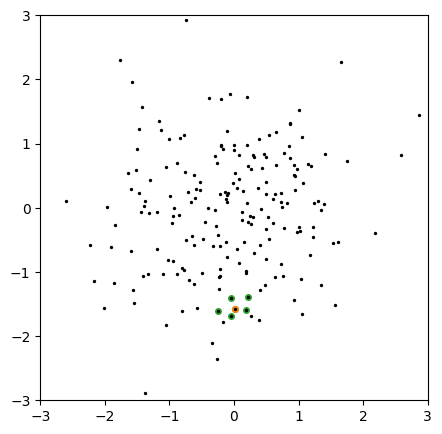

In [80]:
# Generate a few random points
n_points = 200
key, subkey = jax.random.split(key)
points = jax.random.normal(subkey, shape=(n_points, 2))
tree = jk.build_tree(points)
neighbors, distances = jk.query_neighbors(tree, points[0], k=6)

# Plot
plt.figure(figsize=(5,5))
plt.scatter(*points[neighbors].T, s=16, c='C2')
plt.scatter(*points[0], s=16, c='C1')
plt.scatter(*points.T, s=2, c='k')
plt.gca().set(xlim=(-3, 3), ylim=(-3, 3))
plt.show()

## More points with JIT, *highly* recommended to run on GPU

In [81]:
# JIT compilation
build_tree_jit = jax.jit(jk.build_tree, static_argnames=('optimized',))
query_neighbors_jit = jax.jit(jk.query_neighbors, static_argnames=('k',))

In [104]:
# Test with larger number of points (run a second time to see compiled speed)
n_points = 10_000_000
key, subkey = jax.random.split(key)
points = jax.random.uniform(subkey, shape=(n_points, 2))
tree = build_tree_jit(points)
tree

tree(points=Array([[0.910334  , 0.7014866 ],
       [0.7119602 , 0.97091544],
       [0.23990285, 0.8795117 ],
       ...,
       [0.24390602, 0.29322386],
       [0.5586759 , 0.42785048],
       [0.87056625, 0.22717297]], dtype=float32), indices=Array([7477892, 8550255, 6728824, ...,  106064, 7616343,  821052], dtype=int32), split_dims=Array([ 0,  1,  1, ..., -1, -1, -1], dtype=int32))

In [105]:
# Find neighbors for all points (run a second time to see compiled speed)
neighbors, distances = jax.vmap(Partial(query_neighbors_jit, tree, k=6))(points)
neighbors

Array([[      0, 2177704, 3971069, 7195108,  717311, 5177145],
       [      1, 6504328, 4925492, 6431627, 3265470, 8651221],
       [      2, 1155526, 9682017, 7995299, 9812241, 3510567],
       ...,
       [9999997, 5288458,  316077, 7888864, 8866815, 4597139],
       [9999998, 4648801, 7178775, 1896111,  124568, 2722968],
       [9999999, 8272563, 9864688, 2685985, 4187855, 2915625]],      dtype=int32)

In [106]:
# Build scipy KDTree to compare
scipy_tree = KDTree(points)

In [107]:
# Find neighbors for all points again
scipy_neighbors = scipy_tree.query(points, k=6, workers=-1)[1]
scipy_neighbors

array([[      0, 2177704, 3971069, 7195108,  717311, 5177145],
       [      1, 6504328, 4925492, 6431627, 3265470, 8651221],
       [      2, 1155526, 9682017, 7995299, 9812241, 3510567],
       ...,
       [9999997, 5288458,  316077, 7888864, 8866815, 4597139],
       [9999998, 4648801, 7178775, 1896111,  124568, 2722968],
       [9999999, 8272563, 9864688, 2685985, 4187855, 2915625]],
      shape=(10000000, 6))

In [ ]:
# Do all points match? Guessing some issues from floating point precision...
jnp.sum(neighbors == scipy_neighbors) / neighbors.size

Array(0.9999986, dtype=float32)